In [70]:
import numpy as np
import rasterio
import rasterio.mask
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
import torch
import matplotlib as mpl
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os
from rasterio.merge import merge

# Load satellite data

In [82]:
import geopandas as gpd
path = "../data/raw/biomass/Biomas_250mil/lm_bioma_250.shp"
df = gpd.read_file(path)
df['area_6933'] = df.geometry.to_crs("EPSG:6933").area / 10000

In [83]:
df.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [84]:
def merge_mosaic(year, resolution=250):
    path_bio = f"../data/raw/biomass/amazonia/{resolution}m/satellite/" 
    path_bios = [path_bio + name for name in os.listdir(path_bio) if f"-{year}-" in name]
    
    src_files_to_mosaic = []
    for fp in path_bios:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    mosaic, out_trans = merge(src_files_to_mosaic)
    out_meta = src.meta.copy()

    print(src.crs)

    out_meta.update({"driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans,
            "crs": src.crs
            })
    
    out_fp = f"../data/raw/biomass/amazonia/{resolution}m/satellite/" + f"mosaic_{year}.tif"
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.write(mosaic)

In [85]:
for year in [2010,2015,2020]:
    merge_mosaic(year)

EPSG:4674
EPSG:4674
EPSG:4674


In [95]:
# function to load biomass data
def crop_satellite_data(year, shape, resolution=250):
    path_bio = f"../data/raw/biomass/amazonia/{resolution}m/satellite/" 
    path_bio = path_bio + f"mosaic_{year}.tif"
    
    nodata = 0

    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        
        bio_data, out_transform = rasterio.mask.mask(src, shape, crop=True, nodata=nodata)
        # bio_data = bio_data.squeeze()
        out_meta.update({"driver": "GTiff",
                "height": bio_data.shape[1],
                "width": bio_data.shape[2],
                "transform": out_transform})
    out_fp = f"../data/raw/biomass/amazonia/{resolution}m/satellite/" + f"mosaic_{year}.tif"
    with rasterio.open(out_fp, "w", **out_meta) as dest:
        dest.write(bio_data)

In [96]:
for year in [2010,2015,2020]:
    crop_satellite_data(year, shape=[df.geometry[0]])

In [105]:
def transform_crs(year, dst_crs, resolution=250):
    path_bio_in = f"../data/raw/biomass/amazonia/{resolution}m/satellite/" + f"mosaic_{year}.tif"
    with rasterio.open(path_bio_in) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        path_bio_out = f"../data/interim/biomass/amazonia/{resolution}m/satellite/" + f"mosaic_{year}.tif"
        with rasterio.open(path_bio_out, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [106]:
for year in [2010,2015,2020]:
    transform_crs(year, 'EPSG:6933')

In [107]:
def load_satellite_data(year, resolution=250, delta=360):
    path_bio = f"../data/interim/biomass/amazonia/{resolution}m/satellite/"
    path_bio = path_bio + f"mosaic_{year}.tif"
    with rasterio.open(path_bio) as src:
        out_meta = src.meta
        bio_data = src.read()
    bio_data = torch.from_numpy(bio_data)
    bio_data = bio_data.moveaxis(0, -1)

    # print(bio_data.shape)
   
    target_shape = torch.ceil(torch.tensor(bio_data.shape) / delta) * delta + delta
    diff_x = int((target_shape[1] - bio_data.shape[1])/2)
    diff_y = int((target_shape[0] - bio_data.shape[0])/2)
    mod_x = (target_shape[1] - bio_data.shape[1])%2
    mod_y = (target_shape[0] - bio_data.shape[0])%2
    bio_data = torch.nn.functional.pad(bio_data, (0, 0, diff_x, int(diff_x+mod_x), diff_y, int(diff_y+mod_y)), value=0)
    return bio_data, out_meta

In [108]:
satellite_data, meta = load_satellite_data(year=2015)

torch.Size([11466, 12224, 6])


In [113]:
satellite_data.shape

torch.Size([11880, 12600, 6])

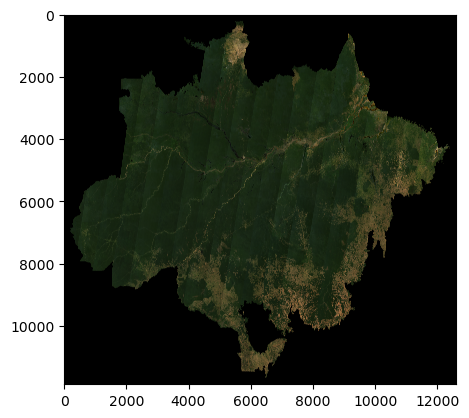

In [110]:
plt.imshow((satellite_data[:,:,[2,1,0]]*0.1).type(torch.uint8))
plt.show()

In [112]:
for year in [2010, 2015, 2020]:
    satellite_data, meta = load_satellite_data(year)
    satellite_data = (satellite_data*0.1).type(torch.uint8)
    torch.save(satellite_data, f"../data/processed_transition/biomass/amazonia/{250}m/" + f"mosaic_{year}.pt")

torch.Size([11466, 12224, 6])
torch.Size([11466, 12224, 6])
torch.Size([11466, 12224, 6])
